In [1]:
import pandas as pd

from textblob import TextBlob
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_score, roc_curve, confusion_matrix

import matplotlib.pyplot as plt

# Loading in the data

In [2]:
# Import tsv file
text_df = pd.read_csv('labeledTrainData.tsv', sep='\t')
text_df.head()

,id,sentiment,review
0,5814_8,1,With all this stuff going down at the moment w...
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi..."
2,7759_3,0,The film starts with a manager (Nicholas Bell)...
3,3630_4,0,It must be assumed that those who praised this...
4,9495_8,1,Superbly trashy and wondrously unpretentious 8...


# Determining Polarity Score and Assigning a Category

In [3]:
# Function created to calculate polarity of each review
def detect_polarity(text):
    return TextBlob(text).sentiment.polarity

# Interpreting the polarity score and assigning Negative or Positive
def getAnalysis(polarity):
    if polarity < 0:
        return 'Negative'
    else:
        return 'Positive'

In [4]:
# Applying the following functions and assigning results to a new column
text_df['Polarity'] = text_df['review'].apply(detect_polarity)
text_df['Analysis'] = text_df['Polarity'].apply(getAnalysis)

In [5]:
text_df.head(2)

,id,sentiment,review,Polarity,Analysis
0,5814_8,1,With all this stuff going down at the moment w...,0.001277,Positive
1,2381_9,1,"\The Classic War of the Worlds\"" by Timothy Hi...",0.256349,Positive


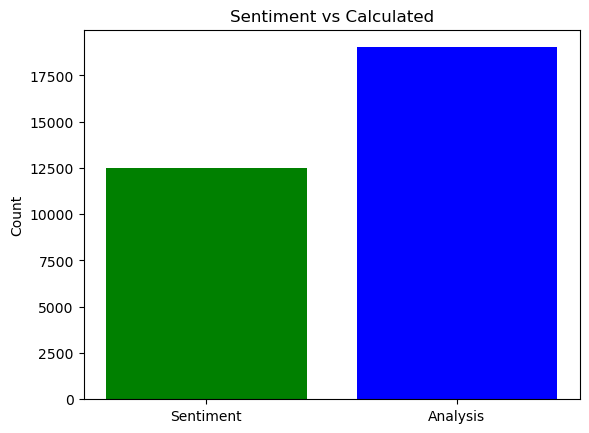

In [6]:
# Visualizing the number of positive sentiments vs the calculated analysis
plt.bar('Sentiment', text_df['sentiment'].sum(), color='green')
plt.bar('Analysis', len(text_df[text_df['Analysis']=='Positive']), color='blue')

plt.title('Sentiment vs Calculated')
plt.ylabel('Count')
plt.show()

# Cleaning/Preparing the Reviews

In [7]:
# [^\w\s] = Match anything that is not alphanumeric or a white space
# Applying a lowercased function to all contents of the variable and removing anything that is not alphanumeric or a space
removed_punc  = text_df['review'].str.replace('[^\w\s]', '', regex=True)

In [8]:
# Tokenizing data to easily remove punctuations
tokenized = removed_punc.apply(lambda x:word_tokenize(x))

In [9]:
# Outlining the stop word language
stop_words = stopwords.words('english')

# Creating a function to iterate over each word in the respective row to remove stop words
def remove_stop(text):
    return [s_word for s_word in text if s_word not in stop_words]

# Applying the stop word remover function
no_stop_words = tokenized.apply(lambda x : remove_stop(x))

In [10]:
# Creating a PorterStemmer instance
porter = PorterStemmer()

# Function responsible for iterating through each word and stripping the suffix 
def porter_words(text):
    return [porter.stem(word)for word in text]

# In line function to loop over each row and apply the porter_words function
stemmed_words = no_stop_words.apply(lambda x: porter_words(x))

In [11]:
# Joining the words per row back together
re_join = stemmed_words.apply(lambda x: ' '.join(x))

# Preparing the Data for Modeling

In [12]:
sentiment_target = text_df['sentiment']

X_train, X_test, y_train, y_test = train_test_split(re_join, sentiment_target, test_size=0.2, random_state=20)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(20000,) (5000,) (20000,) (5000,)


In [13]:
# Creating a TfidfVectorizer instance
tfidf = TfidfVectorizer(lowercase=False)

# Fitting the training data to the vectorizer (this is taking the text and converting it into a value)
feature_matrix = tfidf.fit_transform(X_train)

# Transforming the testing data to the vectorizer
test_matrix = tfidf.transform(X_test)

# Logistic Regression

In [14]:
# Creating a Logistic Regression instance
logistic_regression = LogisticRegression().fit(feature_matrix, y_train)
y_pred = logistic_regression.predict(test_matrix)

# Metrics

In [15]:
confusion_matrix(y_pred, y_test)

array([[2188,  259],
       [ 333, 2220]], dtype=int64)

In [16]:
accuracy = round(accuracy_score(y_pred, y_test),2)*100
precision = round(precision_score(y_pred, y_test),2)*100
recall = round(recall_score(y_pred, y_test),2)*100
f1 = round(f1_score(y_pred, y_test),2)*100

print(f'Accuracy:  {accuracy} %\nPrecision: {precision} %\nRecall: {recall} %\nF1 Score: {f1} %')

Accuracy:  88.0 %
Precision: 90.0 %
Recall: 87.0 %
F1 Score: 88.0 %


## Creating an ROC Curve 

In [17]:
# Getting the predicted probability of getting a positive or negative review (0 or 1)
pred_prob = logistic_regression.predict_proba(test_matrix)

# Selecting only the probabilities for getting a positive result
pos_prob = pred_prob[:,1]

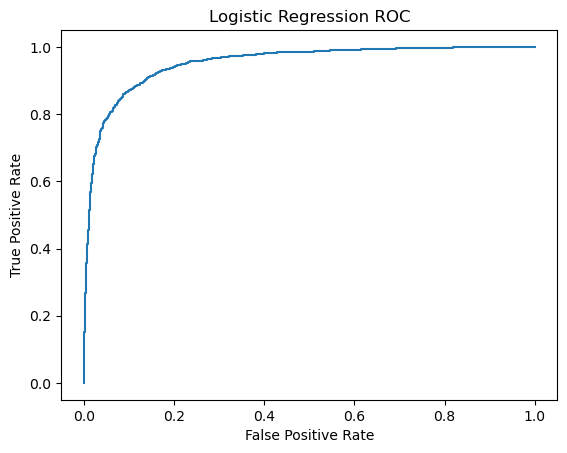

In [18]:
# Plotting the ROC curve
fpr, tpr, threshold = roc_curve(y_test, pos_prob)

plt.plot(fpr, tpr)
plt.title('Logistic Regression ROC')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.show()